In [1]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

#setup the data folder
ss_data_folder = os.path.join(experiment_folder, 'ss_data')

import soundtools as st
import Kwik as oe
from file_tools import experiment as et
from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.basic_plot import plot_raster, sparse_raster
from basic_viewing import basic_plot as bp
from basic_viewing import kwik_functions as kwf


Computer: passaro


In [2]:
# bird and session

bird = 'z007'
sess = 'day-2016-09-10'

# bird = 'z020'
# sess = 'day-2016-06-03'

exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

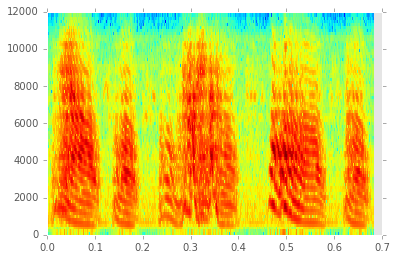

In [3]:
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
m_length = m_chunk.samples
#plt.plot(m_chunk.data)

n_window = 192
n_overlap = 191
sigma = 0.001 * 30000
f_cut = 12000
s_f = m_chunk.sound.s_f

pattern_spectrogram = spectrogram(m_chunk.data[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(pattern_spectrogram[1], 
               pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
               np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]))

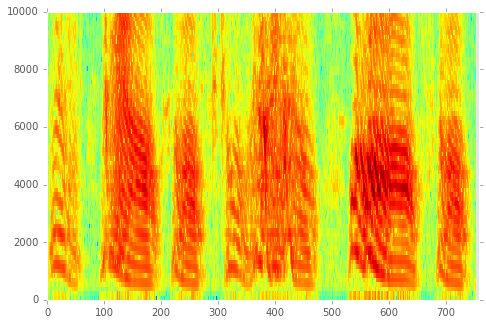

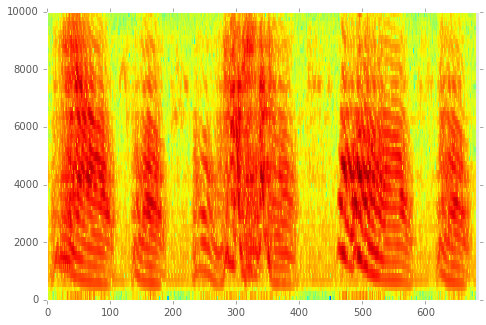

In [4]:
from __future__ import division
from scipy.signal import resample

def normalize(x):
    x_normed = (x - x.min(0)) / x.ptp(0)
    return x_normed

def stream_resample(stream, s_f, new_s_f):
    n_samples = stream.shape[0]
    new_samples = int(n_samples * new_s_f/s_f)
    return resample(stream, new_samples)

def load_syn_stream(bird, syn_sess=1, s_f=44100, new_s_f=30000, file_base='synth_bos'):
    stim_folder = et.file_names(bird)['folders']['stim']
    syn_file = os.path.join(stim_folder, str(syn_sess).zfill(3), file_base + '.dat')
    return stream_resample(np.loadtxt(syn_file), s_f, new_s_f)

def load_alpha_beta(bird, syn_sess=1, s_f=44100, new_s_f=30000, first=None):
    syn_par = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f)
    bos = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f, file_base='bos')
    
    first = syn_par.shape[0] if first is None else first
    
    alpha = syn_par[:first,2]
    alpha[alpha>0] = 0.
    alpha[alpha<0] = 1.
    alpha = alpha*st.envelope(bos[:alpha.shape[0]], window=300, conv_mode='same')
    beta = -(syn_par[:first,1])
 
    beta[beta<0]=0.
    return normalize(alpha), normalize(beta)

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

n_samples = m_chunk.samples - 512
bos = load_syn_stream(bird, file_base='bos')[:,]

spectr_bos, ax = plot_spectrogram(bos[:], 
                                   0, 0, 30000,
                                   n_window = 192, n_overlap=192-1, scaling='spectrum')

spectr_pattern, ax = plot_spectrogram(m_chunk.data[:].flatten(), 
                                   0, 0, 30000,
                                   n_window = 192, n_overlap=192-1, scaling='spectrum')

(97, 19850)

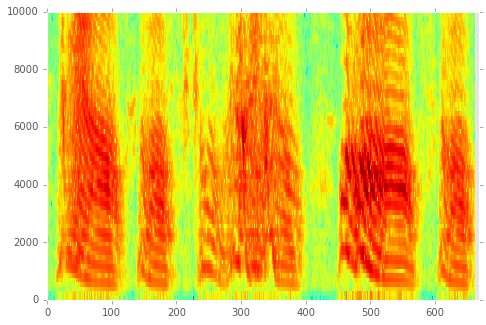

In [103]:
spectr_check, ax = plot_spectrogram(bos[2174+192:2174+192+n_samples],
                                   0, 0, 30000,
                                   n_window = 192, n_overlap=192-1, scaling='spectrum')
spectr_check.shape

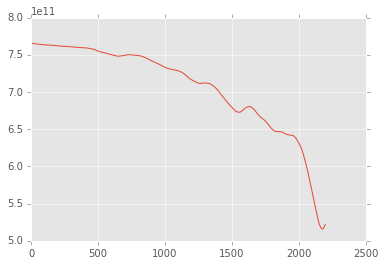

In [5]:
#compute the offset and load the signals
def running_diff(x, y):
    # y is the larger
    n_x = x.shape[1]
    n_y = y.shape[1]
    
    return np.array([np.sum(abs(x - y[:, i: i+n_x])) for i in range(n_y-n_x)])
    
rundif = running_diff(spectr_pattern, spectr_bos)
plt.plot(rundif)
offset = np.argmin(rundif)
syn_par = load_syn_stream(bird)[offset: offset + n_samples,:]
bos = load_syn_stream(bird, file_base='bos')[offset: offset + n_samples,]
synth_bos = load_syn_stream(bird, file_base='song_synth_bos')[offset: offset + n_samples,]
env = load_syn_stream(bird, file_base='env_bos')[offset: offset + n_samples,]
alpha, beta= [x[-n_samples:] for x in load_alpha_beta(bird)]
len_samples = n_samples

In [159]:
syn_par = load_syn_stream(bird)[offset: offset + n_samples,:]
bos = load_syn_stream(bird, file_base='bos')[offset: offset + n_samples,]
synth_bos = load_syn_stream(bird, file_base='song_synth_bos')[offset: offset + n_samples,]
env = load_syn_stream(bird, file_base='env_bos')[offset: offset + n_samples,]
alpha, beta= [x[-n_samples:] for x in load_alpha_beta(bird)]
len_samples = n_samples

In [6]:
alpha.shape

(20041,)

In [7]:
n_samples

20041

(97, 19850)

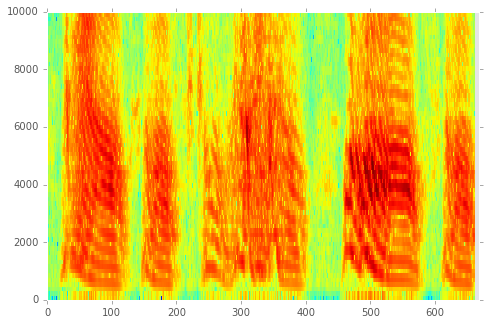

In [8]:
#check
spectr_check, ax = plot_spectrogram(bos[:],
                                   0, 0, 30000,
                                   n_window = 192, n_overlap=192-1, scaling='spectrum')
spectr_check.shape


In [9]:
alpha.shape

(20041,)

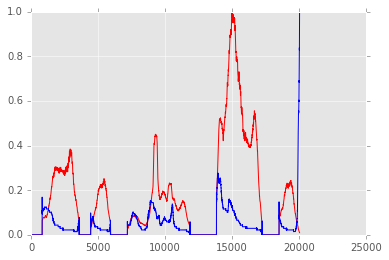

In [10]:
plt.plot(alpha,'r', beta, 'b')

In [11]:
def list_shank_units(bird, sess, shank, shank_file=None, sorted=False):
    meta_dt = np.dtype([('sess', 'S32', 1), ('shank', np.int, 1), ('is_good', 'b', 1)])
    kwik_file = et.open_kwik(bird, sess) if shank_file is None else et.open_kwik(bird, sess, shank_file)
    group = int(shank)
    all_units = kwf.list_units(kwik_file, group=group, sorted=False)
    n_units = all_units.size
    all_meta = np.recarray(n_units, dtype=meta_dt)
    all_meta['sess'] = sess
    all_meta['shank'] = shank
    all_meta['is_good'] = True
    return rfn.merge_arrays((all_meta, all_units), asrecarray=True, flatten=True)

get_shanks_list = et.get_shanks_list

def list_sess_units(bird, sess, sorted=False):
    shanks = get_shanks_list(bird, sess)
    sess_units = None
    for shank in shanks:
        kwik_file = et.open_kwik(bird, sess)
        shank_units = list_shank_units(bird, sess, shank, sorted=False)
        if sess_units is None:
            sess_units = shank_units
        else:
            sess_units = rfn.stack_arrays((sess_units, shank_units))
    return sess_units

all_sess_units = list_sess_units(bird, sess)

In [12]:
# Neural data
shank = 0

kwik_file = et.open_kwik(bird, sess)
m_starts = kwf.apply_rec_offset(kwik_file, m.get_start(), m.get_rec())
#m_starts = m.get_start()
all_units = kwf.list_units(kwik_file, group=shank, sorted=False)

# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print all_units['clu']


[ 0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52 53
 54 55 56 57 58 59  6 60 61 62 63  7  8  9]


selected unit 37


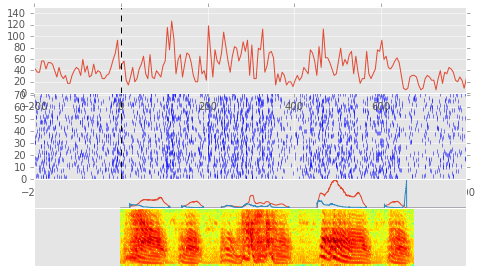

In [13]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def plot_one_raster(unit_clu):
    # instance a Unit object
    unit = Unit(unit_clu, kwik_file=kwik_file)
    # get the spike times (in sample units)
    unit.get_time_stamps()
    # get the sampling rate of the recording
    s_f = unit.sampling_rate
    #get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
    before_ms = 1000
    after_ms = 1600
    start_points = m_starts - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
    rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
    # the raster is an n_trial * m array (where m can be sample or ms).
    # in each row, it contains the timestamps (in samples or ms) of spikes relative to the beginning of the trial
    # plot the raster
    b = np.outer((np.arange(rs.shape[0]) + 1), np.ones(rs.shape[1]))
    plt.figure(unit_clu)
    plt.scatter(rs, b, marker='|')
    plt.xlim(0, before_ms + after_ms)
    plt.show
    
class VizUnit():
    def __init__(self, all_units, pattern_chunk, event):
        self.unit = None
        self.raster = None
        self.clu = all_units['clu']
        self.all_units = all_units
        self.is_good = Checkbox()
        self.fig = None
        self.fig_width = 1
        self.fig_ax = {}
        self.pattern_chunk = pattern_chunk
        self.pattern = pattern_chunk.data.reshape(pattern_chunk.data.size,)
        self.before_ms = 200
        self.after_ms = 800
        self.start_points = None
        self.s_f = pattern_chunk.sound.s_f
        self.spectr = None
        self.event = None
        #display(self.is_bout)
        
        self.init_event(event)
        self.init_fig()
        
    def show(self, i):
        i_clu = i
        self.select_unit(i_clu)
        print 'selected unit {}'.format(i_clu)
        ax1 = self.fig_ax['raster']
        ax2 = self.fig_ax['histogram']
        ax1.cla()
        ax2.cla()
        rast, ax1 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, ax=ax1)
        rast, ax2 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, bin_size=5, ax=ax2)
        display(self.fig)
    
    def select_unit(self, unit_clu):
        self.unit = Unit(unit_clu, kwik_file=kwik_file)
        self.raster = self.unit.get_raster(self.start_points, self.before_ms + self.after_ms, 
                                           span_is_ms=True, return_ms=True)
    
    def init_event(self, event):
        self.event = event
        m_starts = kwf.apply_rec_offset(kwik_file, self.event.get_start(), self.event.get_rec())
        self.start_points = m_starts - np.int(self.s_f * self.before_ms/1000.)
        
    def init_fig(self):
        self.fig = plt.figure()
        self.fig_ax['raster'] = self.fig.add_axes([0,.3,self.fig_width,0.3])
        self.fig_ax['histogram'] = self.fig.add_axes([0,.6,self.fig_width,0.3])
        self.fig_ax['spectrogram'] = self.fig.add_axes([0,0,self.fig_width,0.2])
        self.fig_ax['synthesis'] = self.fig.add_axes([0,.2,self.fig_width,0.1])
        for ax in self.fig_ax.itervalues():
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        self.update_spectrogram()
        self.update_synth_plot()

    def update_spectrogram(self):
        ax = self.fig_ax['spectrogram']
        m_chunk = self.pattern_chunk
        self.spectr, ax = plot_spectrogram(m_chunk.data.reshape(m_chunk.data.size,), 
                                           self.before_ms, self.after_ms, m_chunk.sound.s_f, 
                                           ax=ax, 
                                           n_window = 192, n_overlap=192-1, scaling='spectrum')
    def update_synth_plot(self):
        ax = self.fig_ax['synthesis']
        ax = plot_waveform(alpha[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        ax = plot_waveform(beta[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        
        
        
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.candidates.set_value(self.motiff, 'bout', bc['new'])
    # inspect the result

vu = VizUnit(all_units, m_chunk, m)
widgets.interact(vu.show, i=(0, all_units['clu'].size-1, 1))

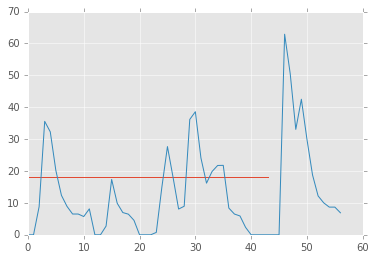

In [345]:
def gimme_good_vec(starts, len_samples, all_units, kwik_file, alpha, beta, s_f=30000, bin_size=10, history_bins=1):
    n_ms = int(len_samples/s_f*1000.)
    bin_size_samples = int(bin_size*s_f/1000.)
    
    n_bins = int(np.floor((n_ms)/bin_size)) + history_bins
    n_starts = starts.size
    n_units = all_units.size
    
    model_pars = bp.col_binned(np.array([alpha, beta]), bin_size_samples)
    sup_vec = np.empty([n_units, n_starts, n_bins], dtype=int)  
    for i, unit_meta in enumerate(all_units):
        clu = unit_meta['clu']
        unit = Unit(clu, kwik_file=kwik_file)
        rs = unit.get_raster(starts - int(history_bins*bin_size*s_f/1000), 
                             n_ms + bin_size*(history_bins-1), 
                             span_is_ms=True, 
                             return_ms=True)
        sup_vec[i, :, :] = bp.col_binned(sparse_raster(rs), bin_size)
    
    good_units = np.where([np.any(sup_vec[u, :, :]) for u in range(sup_vec.shape[0])])
    
    return sup_vec[good_units,:,:][0], model_pars


def unit_array(god_vec, i_u, i_tr, m, N):    
    x = np.vstack([god_vec[i_u, i_tr, i_0: i_0 + N-1] for i_0 in range(m)])
    return x

def all_units_array(god_vec, i_tr, m, N):
    x = np.hstack([unit_array(god_vec, u, i_tr, m, N) for u in range(god_vec.shape[0])])
    return np.hstack([np.ones([x.shape[0], 1]), x])
    
def fit_kernel(god_vec, target, trials, history_bins=10):
    # with this simple support vector make a linear decoder as in warland
    N = history_bins # history bins
    
    v = god_vec.shape[0] #number of units
    M = god_vec.shape[2] #len of recording
    m = M-N
    
    bigR = np.vstack([all_units_array(god_vec, i_tr, m, N) for i_tr in trials])
    s = np.tile(target[:m], trials.size)
    c = np.dot(bigR.T, bigR)
    rc = np.dot(bigR.T, s)
    f = np.dot(np.linalg.inv(c), rc)
    
    return f

def test_kernel(god_vec, target, kernel, trials):
    m = target.size
    N = god_vec.shape[2] - m
    all_fits = np.vstack([np.dot(all_units_array(god_vec, tr_test, m, N), kernel) for tr_test in trials])
    
    all_fits[all_fits<0]=0
    
    err = np.einsum('i,i', target, np.mean(all_fits, axis=0))
    
    return err, all_fits

history_bins = 1
good_vec, good_pars = gimme_good_vec(motiff_starts_kwik, len_samples, all_units, kwik_file, alpha, beta,
                          s_f=s_f, bin_size=15, history_bins=1)

ff = fit_kernel(good_vec, good_pars[1,:], np.arange(65), history_bins=history_bins)

tr_test = 69
m_test = good_vec.shape[2] - history_bins
d, u = test_kernel(good_vec, good_pars[1,:m_test], ff, np.arange(65,66))

plt.plot(u[0])
plt.plot(model_pars[1,:m])

In [338]:
history_bins

2

In [327]:
#parameter sweep
bs = np.arange(5,25,5)
hs = np.arange(1,20,5)

total_trials = sup_vec.shape[1]
test_trials_n = 10

all_trials = np.arange(total_trials)
np.random.shuffle(all_trials)
train_trials = all_trials[:-test_trials_n]
test_trials = all_trials[-test_trials_n:]

n_b = bs.size
n_s = hs.size

d_array = np.zeros([n_b, n_s, 2])

for bin_size in bs:
    print 'Bin Size {}'.format(bin_size)
    bin_R, bin_pars = gimme_good_vec(motiff_starts_kwik, len_samples, all_units, kwik_file, alpha, beta, 
                          s_f=s_f, bin_size=bin_size, history_bins=1)
    
    for history_size in hs:
        m_test = bin_R.shape[2] - history_size
        for i_par in [0, 1]:
            bin_f = fit_kernel(bin_R, bin_pars[i_par,:], test_trials, history_bins=history_size)
            dist, u = test_kernel(bin_R, bin_pars[i_par, :m_test], bin_f, test_trials)
            print 'Hist Size {0}, par {1} dist {2}'.format(history_size, i_par, dist)
            d_array[bin_size, history_size, i_par] = dist


Bin Size 5


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [329]:
bin_R.shape

(56, 71, 134)

In [332]:
bin_pars.shape

(2, 134)

In [254]:
np.arange(total_trials)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70])

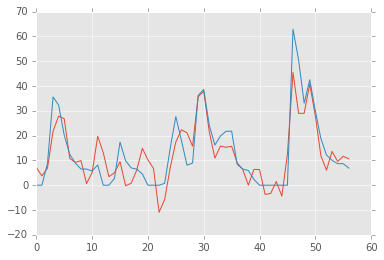

In [218]:
# with this simple support vector make a linear decoder as in warland
N = 10 # history bins
v = god_vec.shape[0] #number of units
M = god_vec.shape[2] #len of recording
m = M-N

R = np.ones([M, 1+N*v])

i_tr=0

def unit_array(god_vec, i_u, i_tr, m):
    x = np.vstack([god_vec[i_u, i_tr, i_0: i_0 + N-1] for i_0 in range(m)])
    return x

def all_units_array(god_vec, i_tr, m):
    x = np.hstack([unit_array(god_vec, u, i_tr, m) for u in range(god_vec.shape[0])])
    return x
    return np.hstack([np.ones([x.shape[0], 1]), x])


R = all_units_array(god_vec, i_tr, m)

n_trials = 65
bigR = np.vstack([all_units_array(god_vec, i_tr, m) for i_tr in range(n_trials)])
s = np.tile(model_pars[1,:m], n_trials)
c = np.dot(bigR.T, bigR)
rc = np.dot(bigR.T, s)
f = np.dot(np.linalg.inv(c), rc)

tr_test = 69
u = np.dot(all_units_array(god_vec, tr_test, m), f)

plt.plot(u)
plt.plot(model_pars[1,:m])

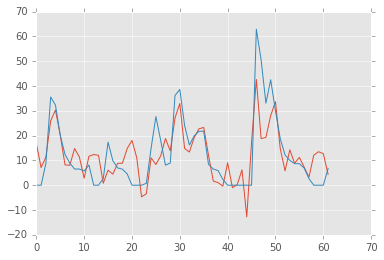

In [347]:
motiff_starts_kwik = kwf.apply_rec_offset(kwik_file, vu.event.get_start(), vu.event.get_rec())
# make an array of n_bins * n_units * n_starts

bin_size = 10
history_bins = 1

# n_ms = int(len_samples/s_f*1000.)
# bin_size_samples = int(bin_size*s_f/1000)

# n_bins = int(np.floor((n_ms)/bin_size)) + history_bins
# n_starts = motiff_starts_kwik.size
# n_units = all_units.size


# sup_vec = np.empty([n_units, n_starts, n_bins], dtype=int)
# model_pars = bp.col_binned(np.array([alpha, beta]), bin_size_samples)

# for i, unit_meta in enumerate(all_units):
#     clu = unit_meta['clu']
#     unit = Unit(clu, kwik_file=kwik_file)
#     rs = unit.get_raster(motiff_starts_kwik - int(history_bins*bin_size*s_f/1000), 
#                          n_ms + bin_size*(history_bins-1), 
#                          span_is_ms=True, 
#                          return_ms=True)
#     sup_vec[i, :, :] = bp.col_binned(sparse_raster(rs), bin_size)
    
# good_units = np.where([np.any(sup_vec[u, :, :]) for u in range(sup_vec.shape[0])])
# god_vec = sup_vec[good_units,:,:][0]

def unit_array(god_vec, i_u, i_tr, m, N):    
    x = np.vstack([god_vec[i_u, i_tr, i_0: i_0 + N-1] for i_0 in range(m)])
    return x

def all_units_array(god_vec, i_tr, m, N):
    x = np.hstack([unit_array(god_vec, u, i_tr, m, N) for u in range(god_vec.shape[0])])
    return np.hstack([np.ones([x.shape[0], 1]), x])

def fit_kernel(god_vec, target, trials, history_bins=10):
    # with this simple support vector make a linear decoder as in warland
    N = history_bins # history bins
    
    v = god_vec.shape[0] #number of units
    M = god_vec.shape[2] #len of recording
    m = M-N
    
    bigR = np.vstack([all_units_array(god_vec, i_tr, m, N) for i_tr in trials])
    s = np.tile(target[:m], trials.size)
    c = np.dot(bigR.T, bigR)
    rc = np.dot(bigR.T, s)
    f = np.dot(np.linalg.inv(c), rc)
    
    return f



god_vec, model_pars = gimme_good_vec(motiff_starts_kwik, len_samples, all_units, kwik_file, alpha, beta, 
                                     s_f=30000, 
                                     bin_size=bin_size, 
                                     history_bins=1)



# with this simple support vector make a linear decoder as in warland
N = 5 # history bins
v = god_vec.shape[0] #number of units
M = god_vec.shape[2] #len of recording
m = M-N

R = np.ones([M, 1+N*v])

i_tr=0

# def unit_array(god_vec, i_u, i_tr, m):
#     x = np.vstack([god_vec[i_u, i_tr, i_0: i_0 + N-1] for i_0 in range(m)])
#     return x

# def all_units_array(god_vec, i_tr, m):
#     x = np.hstack([unit_array(god_vec, u, i_tr, m) for u in range(god_vec.shape[0])])
#     #return x
#     return np.hstack([np.ones([x.shape[0], 1]), x])


R = all_units_array(god_vec, i_tr, m, N)

n_trials = 65
bigR = np.vstack([all_units_array(god_vec, i_tr, m, N) for i_tr in range(n_trials)])
s = np.tile(model_pars[1,:m], n_trials)
c = np.dot(bigR.T, bigR)
rc = np.dot(bigR.T, s)
f = np.dot(np.linalg.inv(c), rc)

tr_test = 69
u = np.dot(all_units_array(god_vec, tr_test, m, N), f)

plt.plot(u)
plt.plot(model_pars[1,:m])

In [313]:
god_vec.shape

(56, 71, 45)

In [320]:
N

10

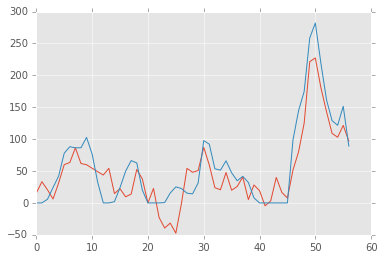

In [212]:
plt.plot(u)
plt.plot(model_pars[0,:m])

In [321]:
m

35

In [208]:
# with this simple support vector make a linear decoder as in warland
N = 10 # history bins
v = god_vec.shape[0] #number of units
M = god_vec.shape[2] #len of recording
m = M-N

R = np.ones([M, 1+N*v])

i_tr=0

def unit_array(god_vec, i_u, i_tr, m):
    x = np.vstack([god_vec[i_u, i_tr, i_0: i_0 + N-1] for i_0 in range(m)])
    return x

def all_units_array(god_vec, i_tr, m):
    x = np.hstack([unit_array(god_vec, u, i_tr, m) for u in range(god_vec.shape[0])])
    return x
    return np.hstack([np.ones([x.shape[0], 1]), x])


R = all_units_array(god_vec, i_tr, m)

n_trials = 65
bigR = np.vstack([all_units_array(god_vec, i_tr, m) for i_tr in range(n_trials)])
s = np.tile(model_pars[0,:m], n_trials)
c = np.dot(bigR.T, bigR)
rc = np.dot(bigR.T, s)
f = np.dot(np.linalg.inv(c), rc)

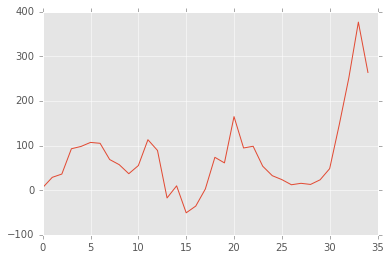

In [209]:
tr_test = 69
u = np.dot(all_units_array(god_vec, tr_test, m), f)
plt.plot(u)

In [179]:
bigR.shape

(2600, 224)

In [180]:
s.shape

(2600,)

In [177]:
model_pars[0,:m].shape

2240

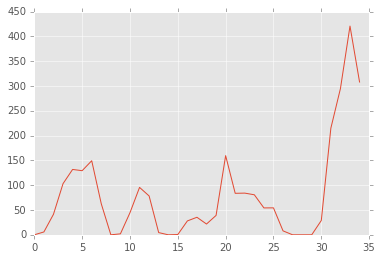

In [186]:
plt.plot(s[:35])

In [142]:
bigR.shape

(62, 225)

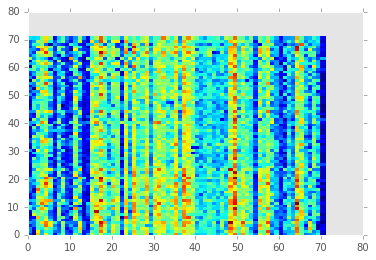

In [18]:
# generate support vector array
# make an array of n_bins * (n_units * (history_bins +1)) * n_starts

motiff_starts_kwik = kwf.apply_rec_offset(kwik_file, vu.event.get_start(), vu.event.get_rec())

bin_size = 10
history_bins = 5

motiff_samples =len_samples #m_chunk.samples
bin_size_samples = int(bin_size*s_f/1000)

bins_motiff = np.int(np.floor(motiff_samples/bin_size_samples))

n_samples = motiff_samples + (history_bins -1)* bin_size_samples
n_ms = int(n_samples/s_f*1000.)

model_pars = bp.col_binned(np.array([alpha, beta]), bin_size_samples)
#plt.plot(np.transpose(model_pars))

n_bins = bins_motiff + history_bins
n_starts = motiff_starts_kwik.size
n_units = all_sess_units.size


sup_vec = np.empty([n_units, n_starts, n_bins], dtype=np.uint16)

# make a support array (history_bins -1) bins longer
for i, unit_meta in enumerate(all_sess_units):
    clu = unit_meta['clu']
    group = unit_meta['shank']
    kwik_file = et.open_kwik(bird, unit_meta['sess'])
    unit = Unit(clu, group=group, kwik_file=kwik_file)
    rs = unit.get_raster(motiff_starts_kwik - history_bins * bin_size_samples, 
                         n_samples, 
                         span_is_ms=False, 
                         return_ms=False)
    sup_vec[i, :, :] = bp.col_binned(sparse_raster(rs), bin_size_samples).astype(np.uint16)

plt.pcolormesh(np.sum(sup_vec[:,:,:], axis=0))
# make a new support vector by enlarging each vector with the previous history_bins-1
new_vec = np.empty((n_units*(history_bins-1), n_starts, n_bins - history_bins + 1 ), dtype=np.uint16)
for i in range(history_bins - 1):
    new_vec[i*n_units: (i+1)*n_units, :, :] = sup_vec[:, :, history_bins-1:]

In [19]:
sup_vec.shape

(64, 71, 71)

In [20]:
model_pars.shape

(2, 67)

In [181]:
#make train set
from sklearn import linear_model

def get_set(support_array, par_array, trial_start=0, trial_end=110, randomize=False):
    start_slice = trial_start
    end_slice = trial_end
    
    n_trials = trial_end - trial_start
    n_bins = support_array.shape[2]
    n_feat = support_array.shape[0]
    
    train_samples = n_trials*n_bins
    
    x_set = support_array[:,start_slice:end_slice,:].reshape([n_feat, n_bins*n_trials])
    y_set = npm.repmat(par_array, 1, n_trials)
    
    
    perm = np.random.permutation(train_samples) if randomize else np.arange(train_samples)
    
    return x_set[:, perm], y_set[:, perm]

In [182]:
model_pars.shape

(2, 67)

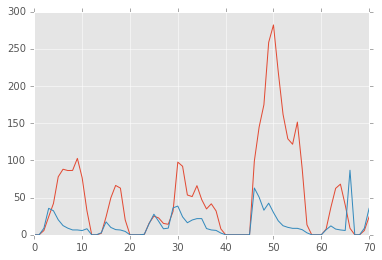

In [169]:
training_trials = new_vec.shape[1] - 5
x_set, y_set = get_set(new_vec, model_pars, trial_end=training_trials, randomize=True)
x_test, y_test = get_set(new_vec, model_pars, trial_start=training_trials, trial_end=training_trials + 5)
plt.plot(np.transpose(y_test[:,:71]))

In [69]:
x_set.shape

(252, 2970)

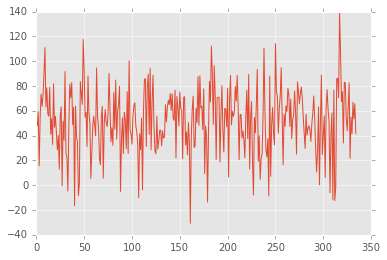

In [172]:
clf = linear_model.Lasso(alpha = .5)
clf.fit (np.transpose(x_set), y_set[0,:])
y_pred = clf.predict(np.transpose(x_test))
plt.plot(y_pred)

In [173]:
import gc
gc.collect()

4150

In [73]:
%reset_selective y_set

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Training batch 0
(256, 71071, 67)
Training batch 1
(256, 71071, 67)
Training batch 2
(256, 71071, 67)
Training batch 3
(256, 71071, 67)
Training batch 4
(256, 71071, 67)
Training batch 5
(256, 71071, 67)
Training batch 6
(256, 71071, 67)
Training batch 7
(256, 71071, 67)
Training batch 8
(256, 71071, 67)
Training batch 9
(256, 71071, 67)


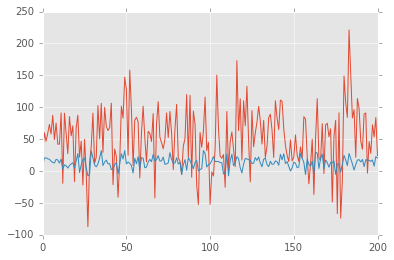

In [174]:
def shuffle_each(array, axis):
    return np.apply_along_axis(np.random.permutation, axis, array)

clf_mv = []
for i_batch in range(10):
    print "Training batch {0}".format(i_batch)
    n_reps = 1000
    ext_vec = shuffle_each(np.concatenate([new_vec for i in range(n_reps)], axis=1), 1) 
    ext_vec = np.concatenate((ext_vec, new_vec), axis=1)

    print ext_vec.shape

    total_trials = ext_vec.shape[1]

    x_set, y_set = get_set(ext_vec, model_pars, trial_end=total_trials-10, randomize=True)
    x_test, y_test = get_set(ext_vec, model_pars, trial_start=total_trials-3, trial_end=total_trials)
    #plt.plot(np.transpose(y_test[:,:]))


    clf_mv.append(linear_model.MultiTaskLasso(alpha=0.5))
    clf_mv[i_batch].fit(np.transpose(x_set), np.transpose(y_set))

#clf = linear_model.Lasso(alpha = .5)
#clf.fit (np.transpose(x_set), y_set[0,:])
y_pred = clf_mv[0].predict(np.transpose(x_test))
plt.plot(y_pred)

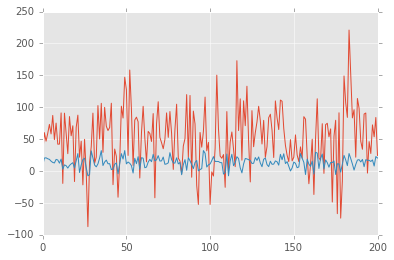

In [179]:
y_pred = clf_mv[5].predict(np.transpose(x_test))
plt.plot(y_pred)

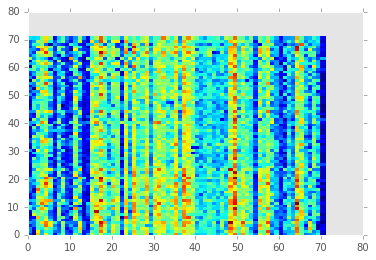

In [180]:
plt.pcolormesh(np.sum(sup_vec[:,:,:], axis=0))

In [10]:
from basic_viewing.basic_plot import plot_raster, sparse_raster
import scipy.signal as sg
from scipy.signal import spectrogram

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def pad_input(sliding_func):
    def out_padded(*args, **kwargs):
        n_window = kwargs['nperseg']
        n_overlap = kwargs['noverlap']
        
        # pad the window so the output is the same size as the input
        assert(n_window%2 == 0)
        before_padding = n_window/2
        after_padding = n_window/2 -1 
        x = np.pad(args[0], (before_padding, after_padding), 'constant', constant_values = (0,0))
        # make the new input to the function
        args = (x,) + args[1:]
        return sliding_func(*args, **kwargs)
    
    return out_padded


fig = plt.figure()
#decorate spectrogram to pad so output and input sizes match
spectrogram = pad_input(spectrogram)
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax